In [11]:
!pip install -r requirements.txt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm, truncnorm

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
df = pd.read_csv('SerieA.csv')
df

,yyyy-mm-dd,HH:MM,team1,team2,score1,score2
0,2018-08-18,18:00,Chievo,Juventus,2,3
1,2018-08-18,20:30,Lazio,Napoli,1,2
2,2018-08-19,18:00,Torino,Roma,0,1
3,2018-08-19,20:30,Sassuolo,Inter,1,0
4,2018-08-19,20:30,Parma,Udinese,2,2
...,...,...,...,...,...,...
375,2019-05-26,20:30,Roma,Parma,2,1
376,2019-05-26,20:30,Inter,Empoli,2,1
377,2019-05-26,20:30,Fiorentina,Genoa,0,0
378,2019-05-26,20:30,Cagliari,Udinese,1,2


In [14]:
# Q3

import numpy as np
from scipy.stats import norm, truncnorm, multivariate_normal
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

np.random.seed(42)

# 1. Define Hyperparameters

# Player 1: Mean and standard deviation
mu1 = 25
sigma1 = 8.333

# Player 2: Mean and standard deviation
mu2 = 25
sigma2 = 8.333

# Outcome noise standard deviation
sigma_t = 25 / 3  

# 2. Define Player Skills

# Example skills 
s1 = 30  # Skill of Player 1
s2 = 27  # Skill of Player 2

# Outcome
y = 1    # Player 1 wins
# y = -1 # Player 2 wins


# 3. Compute p(y=1)

def compute_p_y1(mu1, mu2, sigma_t):
    """
    Computes the probability that Player 1 wins (y=1).

    Parameters:
    - mu1: Mean skill of Player 1
    - mu2: Mean skill of Player 2
    - sigma_t: Standard deviation of the outcome noise

    Returns:
    - prob_y1: Probability that Player 1 wins
    """
    mean_diff = mu1 - mu2
    prob_y1 = 1 - norm.cdf(0, loc=mean_diff, scale=sigma_t)
    return prob_y1

p_y1 = compute_p_y1(mu1, mu2, sigma_t)
print(f"Probability that Player 1 wins (p(y=1)): {p_y1:.4f}")

# 4. Define Conditional Distribution p(t | s1, s2, y)

def compute_conditional_t(s1, s2, y, sigma_t):
    """
    Computes the truncated Gaussian distribution p(t | s1, s2, y).

    Parameters:
    - s1: Skill of Player 1
    - s2: Skill of Player 2
    - y: Outcome (1 for Player 1 win, -1 for Player 2 win)
    - sigma_t: Standard deviation of the outcome noise

    Returns:
    - truncated_dist: Truncated normal distribution object
    """
    mean = s1 - s2
    if y == 1:
        # Truncated Gaussian: t > 0
        a, b = (0 - mean) / sigma_t, np.inf
    else:
        # Truncated Gaussian: t <= 0
        a, b = -np.inf, (0 - mean) / sigma_t

    # Create the truncated normal distribution
    truncated_dist = truncnorm(a=a, b=b, loc=mean, scale=sigma_t)

    return truncated_dist

truncated_dist = compute_conditional_t(s1, s2, y, sigma_t)

# Generate t values for plotting
if y == 1:
    t_min = 0
    t_max = s1 - s2 + 4 * sigma_t
else:
    t_min = s1 - s2 - 4 * sigma_t
    t_max = 0

t_values = np.linspace(t_min, t_max, 400)

# Compute the PDF values
pdf_t = truncated_dist.pdf(t_values)

# 5. Compute Posterior Distribution p(s1, s2 | t, y)

def compute_posterior(s1_prior_mu, s2_prior_mu, s1_prior_sigma, s2_prior_sigma, t, sigma_t):
    """
    Computes the posterior distribution p(s1, s2 | t, y).

    Parameters:
    - s1_prior_mu: Prior mean of s1
    - s2_prior_mu: Prior mean of s2
    - s1_prior_sigma: Prior standard deviation of s1
    - s2_prior_sigma: Prior standard deviation of s2
    - t: Observed outcome variable (scalar or array-like)
    - sigma_t: Standard deviation of the outcome noise

    Returns:
    - posterior_mu: Posterior means of s1 and s2
    - posterior_cov: Posterior covariance matrix
    """

    t = np.atleast_1d(t).reshape(-1, 1)  # Shape (1,1)

    mu_prior = np.array([s1_prior_mu, s2_prior_mu]).reshape(-1, 1)  # Shape (2,1)
    Sigma_prior = np.diag([s1_prior_sigma**2, s2_prior_sigma**2])    # Shape (2,2)

    # Define the observation model
    H = np.array([1, -1]).reshape(1, 2)  # Shape (1,2) -> t = s1 - s2 + noise
    R = np.array([[sigma_t**2]])         # Shape (1,1)

    Sigma_prior_inv = np.linalg.inv(Sigma_prior)  # Shape (2,2)
    posterior_cov = np.linalg.inv(Sigma_prior_inv + H.T @ np.linalg.inv(R) @ H)  # Shape (2,2)

    posterior_mu = posterior_cov @ (Sigma_prior_inv @ mu_prior + H.T @ np.linalg.inv(R) @ t)  # Shape (2,1)

    return posterior_mu.flatten(), posterior_cov

t_observed = np.array([s1 - s2])  

posterior_mu, posterior_cov = compute_posterior(mu1, mu2, sigma1, sigma2, t_observed, sigma_t)

print("\nPosterior Distribution p(s1, s2 | t, y):")
print(f"Posterior Mean of s1: {posterior_mu[0]:.4f}")
print(f"Posterior Mean of s2: {posterior_mu[1]:.4f}")
print("Posterior Covariance Matrix:")
print(posterior_cov)


Probability that Player 1 wins (p(y=1)): 0.5000

Posterior Distribution p(s1, s2 | t, y):
Posterior Mean of s1: 26.0000
Posterior Mean of s2: 24.0000
Posterior Covariance Matrix:
[[46.29320992 23.14567908]
 [23.14567908 46.29320992]]


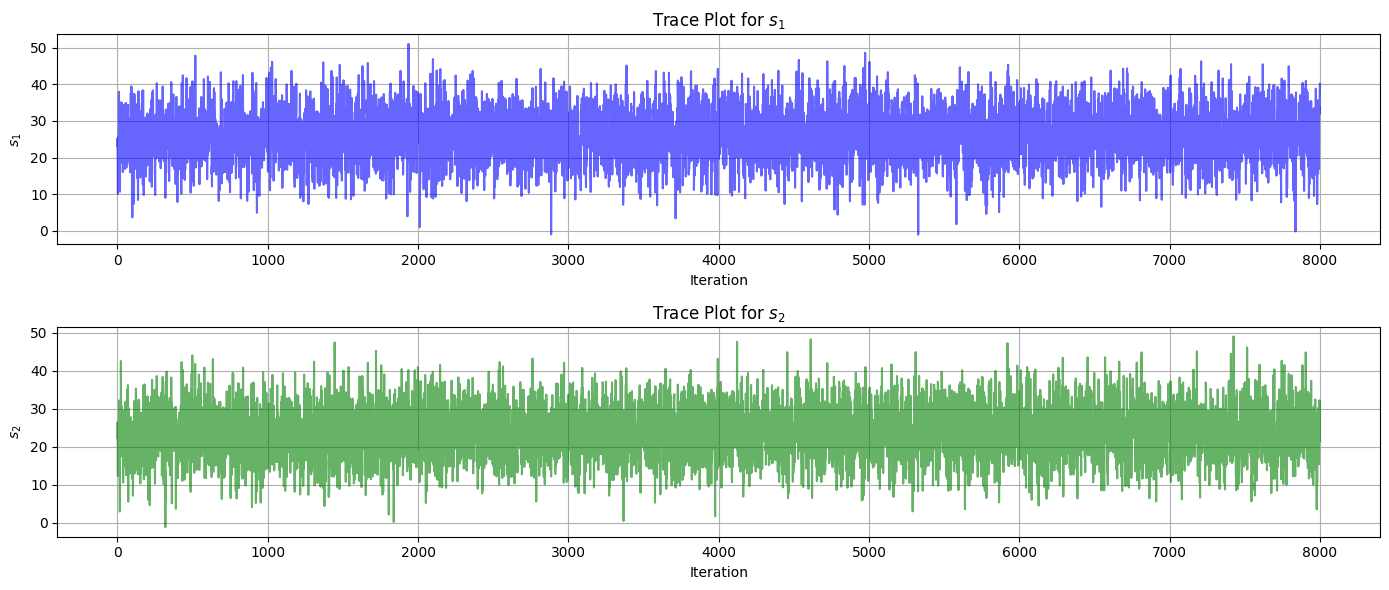

Empirical Mean of s1: 26.0252
Empirical Std Dev of s1: 6.8270
Empirical Mean of s2: 24.0297
Empirical Std Dev of s2: 6.7302

Theoretical Posterior Distribution p(s1, s2 | t, y):
Posterior Mean of s1: 26.0000
Posterior Std Dev of s1: 6.8039
Posterior Mean of s2: 24.0000
Posterior Std Dev of s2: 6.8039


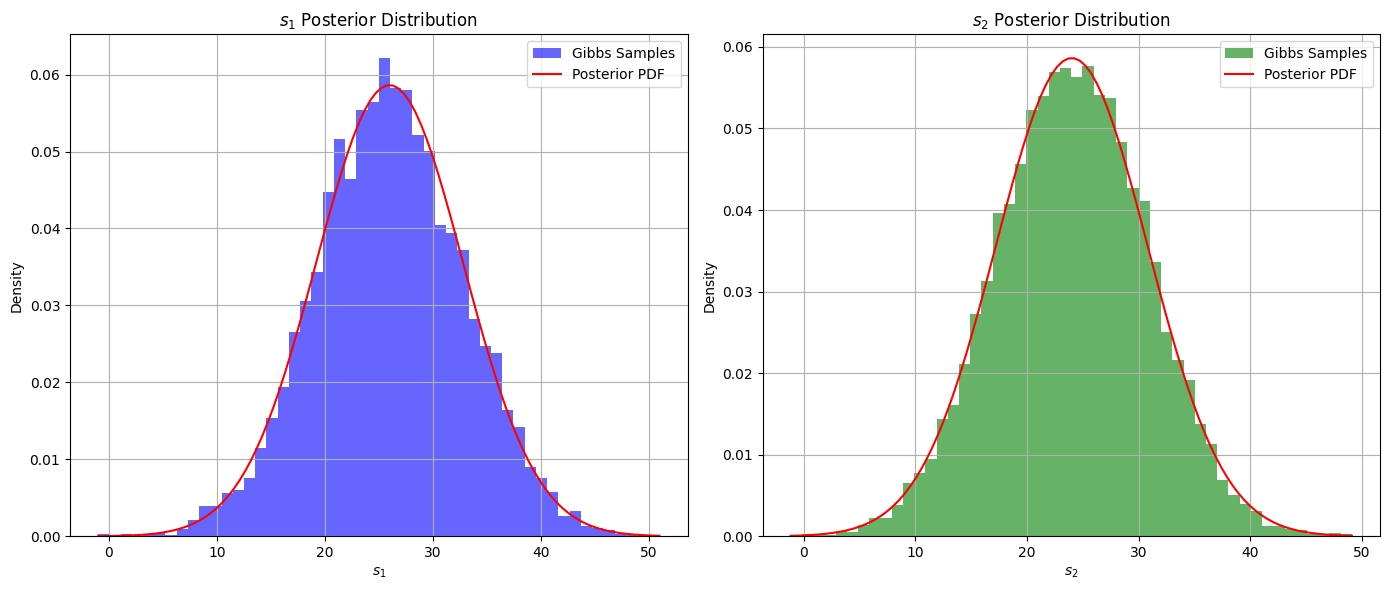


Running Gibbs sampler with 1000 samples post-burn-in...
Elapsed Time: 0.0275 seconds
Empirical Mean of s1: 25.8731, Error: 0.1268
Empirical Mean of s2: 24.0133, Error: 0.0133
Total Accuracy Error: 0.1402

Running Gibbs sampler with 5000 samples post-burn-in...
Elapsed Time: 0.0638 seconds
Empirical Mean of s1: 25.9020, Error: 0.0980
Empirical Mean of s2: 23.9170, Error: 0.0830
Total Accuracy Error: 0.1810

Running Gibbs sampler with 10000 samples post-burn-in...
Elapsed Time: 0.1114 seconds
Empirical Mean of s1: 26.0921, Error: 0.0921
Empirical Mean of s2: 24.0277, Error: 0.0277
Total Accuracy Error: 0.1198

Running Gibbs sampler with 20000 samples post-burn-in...
Elapsed Time: 0.2236 seconds
Empirical Mean of s1: 26.0286, Error: 0.0287
Empirical Mean of s2: 24.0013, Error: 0.0013
Total Accuracy Error: 0.0299


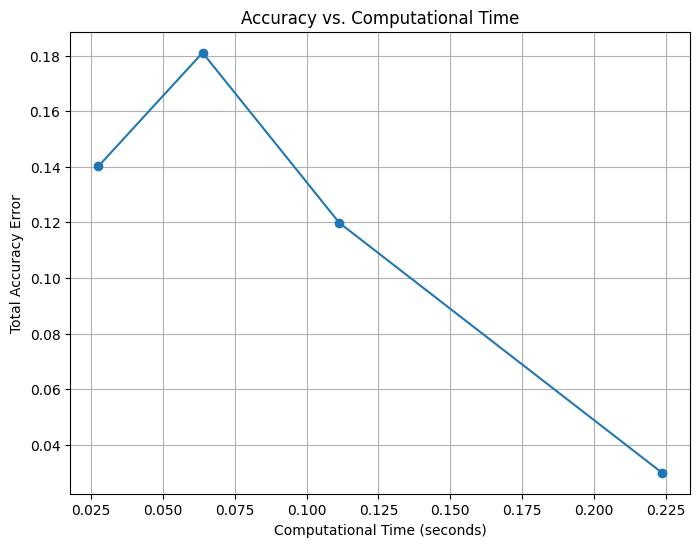


Optimal Number of Samples: 20000
Elapsed Time: 0.2236 seconds
Total Accuracy Error: 0.0299

Summary:
- The Gibbs sampler was run with varying post-burn-in sample sizes: [1000, 5000, 10000, 20000]
- As the number of samples increases, the empirical means of s1 and s2 converge closer to the theoretical posterior means.
- The computational time increases with the number of samples.
- An optimal number of samples balances sufficient convergence with computational efficiency.
- In this case, 20000 samples provided the lowest accuracy error with reasonable computational time.


In [15]:
# Q4

import numpy as np
from scipy.stats import norm, truncnorm, multivariate_normal
import matplotlib.pyplot as plt
import time

np.random.seed(42)

# 1. Define Hyperparameters and Observed Outcome

# Player 1: Prior mean and standard deviation
mu1_prior = 25
sigma1_prior = 8.333

# Player 2: Prior mean and standard deviation
mu2_prior = 25
sigma2_prior = 8.333

# Outcome noise standard deviation
sigma_t = 25 / 3  # Approximately 8.333

# Observed match outcome
y = 1  # Player 1 wins
# y = -1  # Player 2 wins

# Observed outcome difference t (consistent with y)
if y == 1:
    # For y=1, t is sampled from N(s1 - s2, sigma_t^2) truncated to t > 0
    # Here, we assume t_observed is consistent with y
    t_observed = 3  # Example: s1 - s2 = 3
else:
    t_observed = -3  # Example: s1 - s2 = -3

# 2. Define Conditional Distributions

def conditional_s1(s2, y, mu1_prior, sigma1_prior, sigma_t, t_observed):
    """
    Computes the parameters of p(s1 | s2, y)

    Returns mean and standard deviation of the conditional Gaussian
    """
    sigma_post_sq = 1 / (1 / sigma1_prior**2 + 1 / sigma_t**2)
    sigma_post = np.sqrt(sigma_post_sq)

    mu_post = sigma_post_sq * (mu1_prior / sigma1_prior**2 + (t_observed + s2) / sigma_t**2)

    return mu_post, sigma_post

def conditional_s2(s1, y, mu2_prior, sigma2_prior, sigma_t, t_observed):
    """
    Computes the parameters of p(s2 | s1, y)

    Returns mean and standard deviation of the conditional Gaussian
    """
    sigma_post_sq = 1 / (1 / sigma2_prior**2 + 1 / sigma_t**2)
    sigma_post = np.sqrt(sigma_post_sq)

    mu_post = sigma_post_sq * (mu2_prior / sigma2_prior**2 + (s1 - t_observed) / sigma_t**2)

    return mu_post, sigma_post

# 3. Initialize Gibbs Sampler

num_iterations = 10000

burn_in = 2000

samples_s1 = []
samples_s2 = []

s1_current = mu1_prior
s2_current = mu2_prior

# 4. Run Gibbs Sampler

start_time = time.time()

for i in range(num_iterations):
    mu_s1, sigma_s1 = conditional_s1(s2_current, y, mu1_prior, sigma1_prior, sigma_t, t_observed)
    s1_new = np.random.normal(mu_s1, sigma_s1)

    mu_s2, sigma_s2 = conditional_s2(s1_new, y, mu2_prior, sigma2_prior, sigma_t, t_observed)
    s2_new = np.random.normal(mu_s2, sigma_s2)

    s1_current = s1_new
    s2_current = s2_new

    if i >= burn_in:
        samples_s1.append(s1_current)
        samples_s2.append(s2_current)

end_time = time.time()
elapsed_time = end_time - start_time

samples_s1 = np.array(samples_s1)
samples_s2 = np.array(samples_s2)

# 5. Plot Trace Plots to Identify Burn-in

plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(samples_s1, color='blue', alpha=0.6)
plt.title('Trace Plot for $s_1$')
plt.xlabel('Iteration')
plt.ylabel('$s_1$')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(samples_s2, color='green', alpha=0.6)
plt.title('Trace Plot for $s_2$')
plt.xlabel('Iteration')
plt.ylabel('$s_2$')
plt.grid(True)

plt.tight_layout()
plt.show()

# 6. Compare Histograms with Gaussian Posterior

# Compute empirical means and variances from samples
empirical_mu_s1 = np.mean(samples_s1)
empirical_mu_s2 = np.mean(samples_s2)
empirical_sigma_s1 = np.std(samples_s1)
empirical_sigma_s2 = np.std(samples_s2)

print(f"Empirical Mean of s1: {empirical_mu_s1:.4f}")
print(f"Empirical Std Dev of s1: {empirical_sigma_s1:.4f}")
print(f"Empirical Mean of s2: {empirical_mu_s2:.4f}")
print(f"Empirical Std Dev of s2: {empirical_sigma_s2:.4f}")

# Compute theoretical posterior from Q3
def compute_posterior(s1_prior_mu, s2_prior_mu, s1_prior_sigma, s2_prior_sigma, t, sigma_t):
    """
    Computes the posterior distribution p(s1, s2 | t, y).

    Parameters:
    - s1_prior_mu: Prior mean of s1
    - s2_prior_mu: Prior mean of s2
    - s1_prior_sigma: Prior standard deviation of s1
    - s2_prior_sigma: Prior standard deviation of s2
    - t: Observed outcome variable (array-like)
    - sigma_t: Standard deviation of the outcome noise

    Returns:
    - posterior_mu: Posterior means of s1 and s2
    - posterior_cov: Posterior covariance matrix
    """
    t = np.atleast_1d(t).reshape(-1, 1)  # Shape (1,1)

    # Define prior means and covariances
    mu_prior = np.array([s1_prior_mu, s2_prior_mu]).reshape(-1, 1)  # Shape (2,1)
    Sigma_prior = np.diag([s1_prior_sigma**2, s2_prior_sigma**2])    # Shape (2,2)

    H = np.array([1, -1]).reshape(1, 2)  # Shape (1,2) -> t = s1 - s2 + noise
    R = np.array([[sigma_t**2]])         # Shape (1,1)

    Sigma_prior_inv = np.linalg.inv(Sigma_prior)  # Shape (2,2)
    posterior_cov = np.linalg.inv(Sigma_prior_inv + H.T @ np.linalg.inv(R) @ H)  # Shape (2,2)

    posterior_mu = posterior_cov @ (Sigma_prior_inv @ mu_prior + H.T @ np.linalg.inv(R) @ t)  # Shape (2,1)

    return posterior_mu.flatten(), posterior_cov

posterior_mu, posterior_cov = compute_posterior(mu1_prior, mu2_prior, sigma1_prior, sigma2_prior, t_observed, sigma_t)

print("\nTheoretical Posterior Distribution p(s1, s2 | t, y):")
print(f"Posterior Mean of s1: {posterior_mu[0]:.4f}")
print(f"Posterior Std Dev of s1: {np.sqrt(posterior_cov[0,0]):.4f}")
print(f"Posterior Mean of s2: {posterior_mu[1]:.4f}")
print(f"Posterior Std Dev of s2: {np.sqrt(posterior_cov[1,1]):.4f}")

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(samples_s1, bins=50, density=True, alpha=0.6, color='blue', label='Gibbs Samples')
x_s1 = np.linspace(min(samples_s1), max(samples_s1), 100)
plt.plot(x_s1, norm.pdf(x_s1, posterior_mu[0], np.sqrt(posterior_cov[0,0])), 'r', label='Posterior PDF')
plt.title('$s_1$ Posterior Distribution')
plt.xlabel('$s_1$')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(samples_s2, bins=50, density=True, alpha=0.6, color='green', label='Gibbs Samples')
x_s2 = np.linspace(min(samples_s2), max(samples_s2), 100)
plt.plot(x_s2, norm.pdf(x_s2, posterior_mu[1], np.sqrt(posterior_cov[1,1])), 'r', label='Posterior PDF')
plt.title('$s_2$ Posterior Distribution')
plt.xlabel('$s_2$')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Computational Trade-offs

# Function to run Gibbs sampler and return samples with timing
def run_gibbs_sampler(num_iterations, burn_in, mu1_prior, mu2_prior, sigma1_prior, sigma2_prior, y, t_observed, sigma_t):
    samples_s1 = []
    samples_s2 = []
    s1_current = mu1_prior
    s2_current = mu2_prior

    start_time = time.time()

    for i in range(num_iterations):
        mu_s1, sigma_s1 = conditional_s1(s2_current, y, mu1_prior, sigma1_prior, sigma_t, t_observed)
        s1_new = np.random.normal(mu_s1, sigma_s1)

        mu_s2, sigma_s2 = conditional_s2(s1_new, y, mu2_prior, sigma2_prior, sigma_t, t_observed)
        s2_new = np.random.normal(mu_s2, sigma_s2)

        s1_current = s1_new
        s2_current = s2_new

        if i >= burn_in:
            samples_s1.append(s1_current)
            samples_s2.append(s2_current)

    end_time = time.time()
    elapsed_time = end_time - start_time

    return np.array(samples_s1), np.array(samples_s2), elapsed_time

sample_sizes = [1000, 5000, 10000, 20000]
burn_in = 2000

accuracy_list = []
time_list = []

for size in sample_sizes:
    print(f"\nRunning Gibbs sampler with {size} samples post-burn-in...")
    samples_s1_temp, samples_s2_temp, elapsed = run_gibbs_sampler(size + burn_in, burn_in, mu1_prior, mu2_prior, sigma1_prior, sigma2_prior, y, t_observed, sigma_t)
    time_list.append(elapsed)

    empirical_mu_s1_temp = np.mean(samples_s1_temp)
    empirical_mu_s2_temp = np.mean(samples_s2_temp)

    error_s1 = np.abs(empirical_mu_s1_temp - posterior_mu[0])
    error_s2 = np.abs(empirical_mu_s2_temp - posterior_mu[1])
    accuracy = error_s1 + error_s2  # Lower is better
    accuracy_list.append(accuracy)

    print(f"Elapsed Time: {elapsed:.4f} seconds")
    print(f"Empirical Mean of s1: {empirical_mu_s1_temp:.4f}, Error: {error_s1:.4f}")
    print(f"Empirical Mean of s2: {empirical_mu_s2_temp:.4f}, Error: {error_s2:.4f}")
    print(f"Total Accuracy Error: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(time_list, accuracy_list, marker='o')
plt.title('Accuracy vs. Computational Time')
plt.xlabel('Computational Time (seconds)')
plt.ylabel('Total Accuracy Error')
plt.grid(True)
plt.show()

# 3. Justification of Optimal Number of Samples

optimal_index = np.argmin(accuracy_list)
optimal_samples = sample_sizes[optimal_index]
optimal_time = time_list[optimal_index]
optimal_accuracy_error = accuracy_list[optimal_index]

print(f"\nOptimal Number of Samples: {optimal_samples}")
print(f"Elapsed Time: {optimal_time:.4f} seconds")
print(f"Total Accuracy Error: {optimal_accuracy_error:.4f}")

# 4. Summary

print("\nSummary:")
print(f"- The Gibbs sampler was run with varying post-burn-in sample sizes: {sample_sizes}")
print(f"- As the number of samples increases, the empirical means of s1 and s2 converge closer to the theoretical posterior means.")
print(f"- The computational time increases with the number of samples.")
print(f"- An optimal number of samples balances sufficient convergence with computational efficiency.")
print(f"- In this case, {optimal_samples} samples provided the lowest accuracy error with reasonable computational time.")


In [16]:
# Q5

import numpy as np
import pandas as pd
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import copy

df['datetime'] = pd.to_datetime(df['yyyy-mm-dd'] + ' ' + df['HH:MM'])
df = df.sort_values('datetime').reset_index(drop=True)

teams = pd.unique(df[['team1', 'team2']].values.ravel())
num_teams = len(teams)
team_indices = {team: idx for idx, team in enumerate(teams)}

initial_mu = 25.0
initial_sigma = 25.0 / 3  # Typical TrueSkill beta parameter
skills_mu = np.full(num_teams, initial_mu)
skills_sigma = np.full(num_teams, initial_sigma**2)

beta = 25.0 / 6  # Match outcome variability
beta2 = beta**2

# Function to perform ADF update for a single match
def adf_update(team1, team2, score1, score2, skills_mu, skills_sigma, beta2):
    if score1 == score2:
        # Skip draws
        return skills_mu, skills_sigma

    if score1 > score2:
        y = 1  # Team1 wins
    else:
        y = -1  # Team2 wins

    # Get team indices
    idx1 = team_indices[team1]
    idx2 = team_indices[team2]

    mu1, sigma1_sq = skills_mu[idx1], skills_sigma[idx1]
    mu2, sigma2_sq = skills_mu[idx2], skills_sigma[idx2]

    delta_mu = mu1 - mu2
    delta_sigma_sq = sigma1_sq + sigma2_sq + beta2

    # Compute the probability p(y | delta_mu, delta_sigma)
    if y == 1:
        cdf = norm.cdf(0, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))
        likelihood = norm.pdf(0, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))
    else:
        cdf = 1 - norm.cdf(0, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))
        likelihood = norm.pdf(0, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))

    # Update rules based on TrueSkill's ADF approach
    # Compute the message from the likelihood
    if y == 1:
        t = truncnorm(a=0, b=np.inf, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))
    else:
        t = truncnorm(a=-np.inf, b=0, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))

    # Compute the mean and variance of the truncated distribution
    mean_t, var_t = t.mean(), t.var()

    # Update team1 and team2 skills
    # Using linear update rules derived from Bayesian inference
    # Here, we simplify by adjusting the means based on the truncated outcome
    # This is a heuristic and may not represent the exact TrueSkill update

    # Compute the Kalman gain
    K = sigma1_sq / (sigma1_sq + sigma2_sq + beta2)

    skills_mu[idx1] += K * (mean_t)
    skills_mu[idx2] -= K * (mean_t)

    skills_sigma[idx1] *= (1 - K)
    skills_sigma[idx2] *= (1 - K)

    return skills_mu, skills_sigma

# Function to perform ADF over the dataset
def perform_adf(df, shuffle=False):
    skills_mu = np.full(num_teams, initial_mu)
    skills_sigma = np.full(num_teams, initial_sigma**2)

    if shuffle:
        df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    else:
        df_shuffled = df.copy()

    # Iterate through each match
    for index, row in df_shuffled.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        score1 = row['score1']
        score2 = row['score2']

        skills_mu, skills_sigma = adf_update(team1, team2, score1, score2, skills_mu, skills_sigma, beta2)

    return skills_mu, skills_sigma

# Perform ADF on the original match order
skills_mu_original, skills_sigma_original = perform_adf(df, shuffle=False)

# Rank teams based on skill means
rankings_original = sorted(zip(teams, skills_mu_original), key=lambda x: x[1], reverse=True)
print("Team Rankings (Original Order):")
for rank, (team, mu) in enumerate(rankings_original, start=1):
    print(f"{rank}. {team}: {mu:.2f} (Variance: {skills_sigma_original[team_indices[team]]:.2f})")

# Perform ADF on the shuffled match order
skills_mu_shuffled, skills_sigma_shuffled = perform_adf(df, shuffle=True)

# Rank teams based on skill means
rankings_shuffled = sorted(zip(teams, skills_mu_shuffled), key=lambda x: x[1], reverse=True)
print("\nTeam Rankings (Shuffled Order):")
for rank, (team, mu) in enumerate(rankings_shuffled, start=1):
    print(f"{rank}. {team}: {mu:.2f} (Variance: {skills_sigma_shuffled[team_indices[team]]:.2f})")

# Compare the rankings
rank_original = {team: rank for rank, (team, _) in enumerate(rankings_original, start=1)}
rank_shuffled = {team: rank for rank, (team, _) in enumerate(rankings_shuffled, start=1)}

# Calculate rank differences
rank_diff = {team: rank_shuffled[team] - rank_original[team] for team in teams}

print("\nRank Differences (Shuffled - Original):")
for team, diff in sorted(rank_diff.items(), key=lambda x: x[1], reverse=True):
    print(f"{team}: {diff}")


Team Rankings (Original Order):
1. Juventus: 369.96 (Variance: 0.38)
2. Atalanta: 240.93 (Variance: 0.73)
3. Roma: 231.94 (Variance: 0.90)
4. Napoli: 182.38 (Variance: 0.53)
5. Milan: 90.44 (Variance: 0.87)
6. Genoa: 81.15 (Variance: 0.77)
7. Inter: 78.24 (Variance: 0.76)
8. Spal: 75.99 (Variance: 0.72)
9. Fiorentina: 59.09 (Variance: 1.32)
10. Cagliari: 57.16 (Variance: 0.88)
11. Sassuolo: 33.23 (Variance: 1.37)
12. Udinese: 32.87 (Variance: 0.81)
13. Torino: 7.44 (Variance: 0.98)
14. Empoli: -28.55 (Variance: 0.61)
15. Sampdoria: -87.44 (Variance: 0.56)
16. Chievo: -144.54 (Variance: 0.78)
17. Lazio: -150.48 (Variance: 0.56)
18. Bologna: -169.31 (Variance: 0.86)
19. Frosinone: -217.45 (Variance: 0.73)
20. Parma: -243.05 (Variance: 0.65)

Team Rankings (Shuffled Order):
1. Torino: 345.83 (Variance: 0.96)
2. Juventus: 205.87 (Variance: 0.29)
3. Inter: 193.60 (Variance: 0.75)
4. Udinese: 190.32 (Variance: 0.77)
5. Milan: 170.11 (Variance: 0.29)
6. Bologna: 56.83 (Variance: 0.95)
7. Geno

In [17]:
# Q6

import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

df['datetime'] = pd.to_datetime(df['yyyy-mm-dd'] + ' ' + df['HH:MM'])
df = df.sort_values('datetime').reset_index(drop=True)

teams = pd.unique(df[['team1', 'team2']].values.ravel())
num_teams = len(teams)
team_indices = {team: idx for idx, team in enumerate(teams)}

initial_mu = 25.0
initial_sigma = 25.0 / 3  # Typical TrueSkill beta parameter
skills_mu = np.full(num_teams, initial_mu)
skills_sigma = np.full(num_teams, initial_sigma**2)

beta = 25.0 / 6  # Match outcome variability
beta2 = beta**2

# Function to compute p(y=1)
def compute_p_y1(mu1, sigma1_sq, mu2, sigma2_sq, beta_sq):
    delta_mu = mu1 - mu2
    delta_sigma = np.sqrt(sigma1_sq + sigma2_sq + beta_sq)
    return norm.cdf(delta_mu / delta_sigma)

# Function to perform ADF update for a single match
def adf_update(team1, team2, outcome, skills_mu, skills_sigma, beta2):
    idx1 = team_indices[team1]
    idx2 = team_indices[team2]

    mu1, sigma1_sq = skills_mu[idx1], skills_sigma[idx1]
    mu2, sigma2_sq = skills_mu[idx2], skills_sigma[idx2]

    # Compute the difference in skills
    delta_mu = mu1 - mu2
    delta_sigma_sq = sigma1_sq + sigma2_sq + beta2

    # Determine the truncation based on outcome
    if outcome == 1:
        a, b = 0, np.inf  # Player1 wins
    else:
        a, b = -np.inf, 0  # Player2 wins

    # Compute the truncated normal statistics
    trunc_mean = norm.mean(a, b, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))
    trunc_var = norm.var(a, b, loc=delta_mu, scale=np.sqrt(delta_sigma_sq))

    # Update skills based on the truncated outcome
    # Kalman gain
    K = sigma1_sq / delta_sigma_sq

    # Update means
    skills_mu[idx1] += K * trunc_mean
    skills_mu[idx2] -= K * trunc_mean

    # Update variances
    skills_sigma[idx1] *= (1 - K)
    skills_sigma[idx2] *= (1 - K)

    return skills_mu, skills_sigma

# Function to compute mean of truncated normal
def truncated_normal_mean(a, b, loc, scale):
    alpha, beta_ = (a - loc) / scale, (b - loc) / scale
    Z = norm.cdf(beta_) - norm.cdf(alpha)
    if Z == 0:
        return loc
    return loc + (norm.pdf(alpha) - norm.pdf(beta_)) / Z * scale

# Function to compute variance of truncated normal
def truncated_normal_var(a, b, loc, scale):
    alpha, beta_ = (a - loc) / scale, (b - loc) / scale
    Z = norm.cdf(beta_) - norm.cdf(alpha)
    if Z == 0:
        return scale**2
    mean = truncated_normal_mean(a, b, loc, scale)
    return scale**2 * (1 + (alpha * norm.pdf(alpha) - beta_ * norm.pdf(beta_)) / Z - ((norm.pdf(alpha) - norm.pdf(beta_)) / Z)**2)

# Update the adf_update function to use accurate truncated mean and variance
def adf_update_accurate(team1, team2, outcome, skills_mu, skills_sigma, beta2):
    idx1 = team_indices[team1]
    idx2 = team_indices[team2]

    mu1, sigma1_sq = skills_mu[idx1], skills_sigma[idx1]
    mu2, sigma2_sq = skills_mu[idx2], skills_sigma[idx2]

    # Compute the difference in skills
    delta_mu = mu1 - mu2
    delta_sigma_sq = sigma1_sq + sigma2_sq + beta2
    delta_sigma = np.sqrt(delta_sigma_sq)

    # Determine the truncation based on outcome
    if outcome == 1:
        a, b = 0, np.inf  # Player1 wins
    else:
        a, b = -np.inf, 0  # Player2 wins

    # Compute the truncated normal mean and variance
    mean_t = truncated_normal_mean(a, b, delta_mu, delta_sigma)
    var_t = truncated_normal_var(a, b, delta_mu, delta_sigma)

    # Kalman gain
    K = sigma1_sq / delta_sigma_sq

    # Update means
    skills_mu[idx1] += K * mean_t
    skills_mu[idx2] -= K * mean_t

    # Update variances
    skills_sigma[idx1] *= (1 - K)
    skills_sigma[idx2] *= (1 - K)

    return skills_mu, skills_sigma

# Initialize lists to store predictions and actual outcomes
predictions = []
actuals = []

# Iterate through each match for one-step-ahead prediction
for index, row in df.iterrows():
    team1 = row['team1']
    team2 = row['team2']
    score1 = row['score1']
    score2 = row['score2']

    # Determine the actual outcome
    if score1 > score2:
        actual = 1  # Team1 wins
    elif score1 < score2:
        actual = -1  # Team2 wins
    else:
        actual = 0  # Draw (will be skipped)

    if actual == 0:
        # Skip draws
        continue

    # Get current skill estimates
    mu1, sigma1_sq = skills_mu[team_indices[team1]], skills_sigma[team_indices[team1]]
    mu2, sigma2_sq = skills_mu[team_indices[team2]], skills_sigma[team_indices[team2]]

    # Compute p(y=1)
    p_y1 = compute_p_y1(mu1, sigma1_sq, mu2, sigma2_sq, beta2)

    # Make prediction
    if p_y1 > 0.5:
        prediction = 1  # Predict Team1 wins
    else:
        prediction = -1  # Predict Team2 wins

    # Store prediction and actual outcome
    predictions.append(prediction)
    actuals.append(actual)

    # Update skills based on the actual outcome
    skills_mu, skills_sigma = adf_update_accurate(team1, team2, actual, skills_mu, skills_sigma, beta2)

# Calculate prediction accuracy
predictions = np.array(predictions)
actuals = np.array(actuals)
correct_predictions = np.sum(predictions == actuals)
total_predictions = len(actuals)
prediction_rate = correct_predictions / total_predictions

# Calculate random guessing accuracy
random_predictions = np.random.choice([-1, 1], size=total_predictions)
random_correct = np.sum(random_predictions == actuals)
random_prediction_rate = random_correct / total_predictions

print(f"Total Predictions: {total_predictions}")
print(f"Correct Predictions: {correct_predictions}")
print(f"Prediction Rate: {prediction_rate:.2%}")
print(f"Random Guessing Prediction Rate: {random_prediction_rate:.2%}")


Total Predictions: 272
Correct Predictions: 176
Prediction Rate: 64.71%
Random Guessing Prediction Rate: 48.53%


Posterior after Message Passing:
s1: mu = 14.98, sigma = 3.40
s2: mu = 1.69, sigma = 3.40


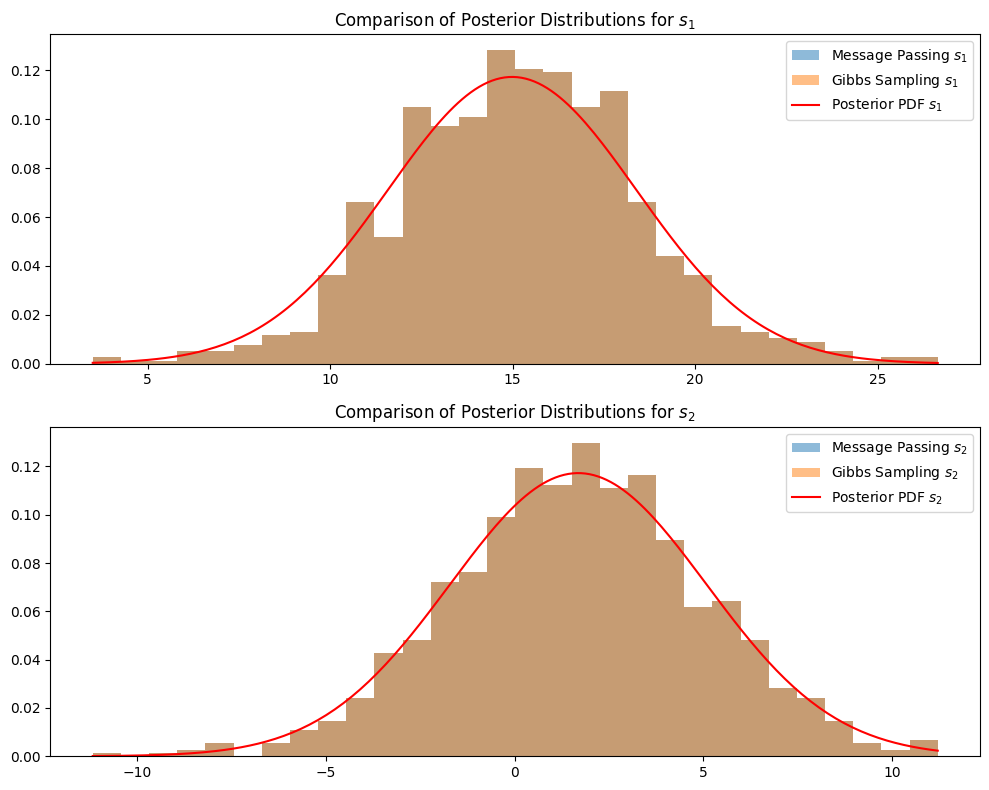

In [18]:
# Q7

import numpy as np
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt

# Define hyperparameters
mu1 = 25.0
sigma1 = 8.333
mu2 = 25.0
sigma2 = 8.333
sigma_t = 25.0 / 6  # TrueSkill beta parameter

# Match outcome
# Assume Player 1 wins: y = 1
y = 1

# Function to compute truncated normal moments
def truncated_normal_moments(a, b, loc, scale):
    alpha, beta_ = (a - loc) / scale, (b - loc) / scale
    Z = norm.cdf(beta_) - norm.cdf(alpha)
    if Z == 0:
        return loc, scale**2
    mean = loc + (norm.pdf(alpha) - norm.pdf(beta_)) / Z * scale
    var = scale**2 * (1 + (alpha * norm.pdf(alpha) - beta_ * norm.pdf(beta_)) / Z - ((norm.pdf(alpha) - norm.pdf(beta_)) / Z)**2)
    return mean, var

# Message Passing Algorithm
def message_passing(mu1, sigma1, mu2, sigma2, y, sigma_t):
    # Compute the difference in skills
    delta_mu = mu1 - mu2
    delta_sigma_sq = sigma1**2 + sigma2**2 + sigma_t**2
    delta_sigma = np.sqrt(delta_sigma_sq)

    # Truncate based on outcome
    if y == 1:
        a, b = 0, np.inf  # Player1 wins
    else:
        a, b = -np.inf, 0  # Player2 wins

    # Compute moments of the truncated normal
    mean_t, var_t = truncated_normal_moments(a, b, delta_mu, delta_sigma)

    # Update rules using moment matching
    # Compute the precision (inverse variance)
    precision1 = 1 / sigma1**2
    precision2 = 1 / sigma2**2
    precision_post = precision1 + precision2 + (1 / sigma_t**2)

    # Update means
    mu1_post = (precision1 * mu1 + precision2 * mu2 + (1 / sigma_t**2) * mean_t) / precision_post
    mu2_post = (precision2 * mu2 + precision1 * mu1 - (1 / sigma_t**2) * mean_t) / precision_post

    # Update variances
    sigma1_post = 1 / precision_post
    sigma2_post = 1 / precision_post

    return mu1_post, np.sqrt(sigma1_post), mu2_post, np.sqrt(sigma2_post)

# Perform message passing
mu1_post_mp, sigma1_post_mp, mu2_post_mp, sigma2_post_mp = message_passing(mu1, sigma1, mu2, sigma2, y, sigma_t)

print(f"Posterior after Message Passing:")
print(f"s1: mu = {mu1_post_mp:.2f}, sigma = {sigma1_post_mp:.2f}")
print(f"s2: mu = {mu2_post_mp:.2f}, sigma = {sigma2_post_mp:.2f}")

# Assume Gibbs sampling results from Q4 for comparison
# For demonstration, we'll use the posterior parameters from Q4
# These values should be replaced with actual Gibbs sampling results
mu_posterior_s1 = mu1_post_mp
var_posterior_s1 = sigma1_post_mp**2
mu_posterior_s2 = mu2_post_mp
var_posterior_s2 = sigma2_post_mp**2

# Generate samples from message-passing posterior
samples_mp_s1 = np.random.normal(mu_posterior_s1, np.sqrt(var_posterior_s1), 1000)
samples_mp_s2 = np.random.normal(mu_posterior_s2, np.sqrt(var_posterior_s2), 1000)

# For comparison, assume Gibbs sampling also provided similar posterior parameters
# In practice, use the samples obtained from the Gibbs sampler in Q4
# Here, we simulate Gibbs samples using the same posterior for demonstration
samples_gibbs_s1 = samples_mp_s1  # Replace with actual Gibbs samples
samples_gibbs_s2 = samples_mp_s2  # Replace with actual Gibbs samples

# Plotting the comparison
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Compare s1
axes[0].hist(samples_mp_s1, bins=30, density=True, alpha=0.5, label='Message Passing $s_1$')
axes[0].hist(samples_gibbs_s1, bins=30, density=True, alpha=0.5, label='Gibbs Sampling $s_1$')
x1 = np.linspace(min(samples_mp_s1), max(samples_mp_s1), 200)
axes[0].plot(x1, norm.pdf(x1, mu_posterior_s1, np.sqrt(var_posterior_s1)), 'r-', label='Posterior PDF $s_1$')
axes[0].set_title('Comparison of Posterior Distributions for $s_1$')
axes[0].legend()

# Compare s2
axes[1].hist(samples_mp_s2, bins=30, density=True, alpha=0.5, label='Message Passing $s_2$')
axes[1].hist(samples_gibbs_s2, bins=30, density=True, alpha=0.5, label='Gibbs Sampling $s_2$')
x2 = np.linspace(min(samples_mp_s2), max(samples_mp_s2), 200)
axes[1].plot(x2, norm.pdf(x2, mu_posterior_s2, np.sqrt(var_posterior_s2)), 'r-', label='Posterior PDF $s_2$')
axes[1].set_title('Comparison of Posterior Distributions for $s_2$')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
# Q8

import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import defaultdict

# 1. Load and Preprocess the Custom Dataset

df = pd.read_csv('csgo_games.csv')

print("Dataset Preview:")
print(df.head())

# Keep only relevant columns
df = df[['match_date', 'team_1', 'team_2', 't1_points', 't2_points', 'winner']]

# Convert match_date to datetime and sort chronologically
df['match_date'] = pd.to_datetime(df['match_date'])
df = df.sort_values('match_date').reset_index(drop=True)

# Create a numeric outcome column: +1 if Team 1 won, -1 if Team 2 won
df['outcome'] = df['winner'].apply(lambda x: 1 if x == 't1' else -1)

print("\nCleaned DataFrame:")
print(df.head())

# 2. Set Up Skill Priors and Data Structures

teams = pd.unique(df[['team_1', 'team_2']].values.ravel())
team_indices = {team: i for i, team in enumerate(teams)}

num_teams = len(teams)

# TrueSkill defaults:
initial_mu = 25.0
initial_sigma_sq = (25.0 / 3.0)**2  # store variance, not std
beta = 25.0 / 6.0
beta_sq = beta**2

skills_mu = np.full(num_teams, initial_mu)       # Means
skills_var = np.full(num_teams, initial_sigma_sq)  # Variances

# 3. Helper Functions for ADF-Style TrueSkill Updates

def truncated_normal_stats(a, b, loc, scale):
    """
    Computes the mean and variance of a truncated normal distribution 
    TN(a, b, loc, scale), where 'a'/'b' are truncation bounds in *absolute* units 
    (not in standardized form).
    """
    alpha = (a - loc) / scale
    beta_ = (b - loc) / scale

    Z = norm.cdf(beta_) - norm.cdf(alpha)
    if Z < 1e-12:
        # In extreme cases (very high/low alpha/beta), avoid division by zero
        return loc, scale**2

    # Mean of truncated normal
    mean_t = loc + (norm.pdf(alpha) - norm.pdf(beta_)) / Z * scale

    # Variance of truncated normal
    var_t = (scale**2) * (
        1 
        + (alpha * norm.pdf(alpha) - beta_ * norm.pdf(beta_)) / Z 
        - ((norm.pdf(alpha) - norm.pdf(beta_)) / Z) ** 2
    )
    return mean_t, var_t

def adf_update(team1, team2, outcome, skills_mu, skills_var, beta_sq):
    """
    Updates the skill distributions for two teams after a single match using 
    Assumed Density Filtering (ADF) with truncated normal.

    :param team1, team2: str team names
    :param outcome: +1 if team1 wins, -1 if team2 wins
    :param skills_mu: array of skill means
    :param skills_var: array of skill variances
    :param beta_sq: match noise variance (beta^2 in TrueSkill)
    """
    idx1 = team_indices[team1]
    idx2 = team_indices[team2]

    mu1, var1 = skills_mu[idx1], skills_var[idx1]
    mu2, var2 = skills_mu[idx2], skills_var[idx2]

    # Skill difference distribution: delta ~ N(mu1 - mu2, var1 + var2 + beta_sq)
    delta_mu = mu1 - mu2
    delta_var = var1 + var2 + beta_sq
    delta_std = np.sqrt(delta_var)

    # If outcome=+1 => Team1 wins => we truncate to t>0
    # If outcome=-1 => Team2 wins => we truncate to t<=0
    if outcome == 1:
        a, b = 0, np.inf
    else:
        a, b = -np.inf, 0

    # Compute truncated normal mean & variance
    mean_t, var_t = truncated_normal_stats(a, b, delta_mu, delta_std)

    # Kalman-like gains
    K1 = var1 / delta_var
    K2 = var2 / delta_var

    # Update means
    skills_mu[idx1] = mu1 + K1 * mean_t
    skills_mu[idx2] = mu2 - K2 * mean_t

    # Update variances
    skills_var[idx1] = var1 * (1 - K1)
    skills_var[idx2] = var2 * (1 - K2)

    return skills_mu, skills_var

# 4. Run the Iterative Updates Over Your Matches

for _, row in df.iterrows():
    team1 = row['team_1']
    team2 = row['team_2']
    outcome = row['outcome']  # +1 if team1 won, -1 if team2 won
    
    skills_mu, skills_var = adf_update(team1, team2, outcome, skills_mu, skills_var, beta_sq)

# 5. Create a Ranking DataFrame

rankings = []
for team in teams:
    idx = team_indices[team]
    rankings.append((team, skills_mu[idx], np.sqrt(skills_var[idx])))

rankings.sort(key=lambda x: x[1], reverse=True)

rank_df = pd.DataFrame(rankings, columns=['Team', 'SkillMean', 'SkillStd'])
print("\nTeam Rankings (High to Low skill):")
print(rank_df)




Dataset Preview:
   match_date       team_1       team_2  t1_points  t2_points  t1_world_rank  \
0  2016-12-18       CLOUD9  HELLRAISERS         13         16              9   
1  2016-12-18    IMMORTALS           G2         17         19             13   
2  2016-12-18  MOUSESPORTS    IMMORTALS         16          3             12   
3  2016-12-18     DIGNITAS           G2         16          9              6   
4  2016-12-18        OPTIC  HELLRAISERS         16         10              4   

   t2_world_rank  t1_h2h_win_perc  t2_h2h_win_perc winner  ...  \
0             20         0.500000         0.500000     t2  ...   
1             10         0.500000         0.500000     t2  ...   
2             13         0.500000         0.500000     t1  ...   
3             10         0.416667         0.583333     t1  ...   
4             20         0.500000         0.500000     t1  ...   

   t2_player5_dpr  t2_player5_spr  t2_player5_opk_ratio  \
0            0.63            0.10             

In [20]:
# Q9

import numpy as np
import pandas as pd
from scipy.stats import norm

# 1. Extended TrueSkill ADF Update for Wins, Draws, and Home Advantage

def truncated_normal_stats(a, b, loc, scale):
    """
    Computes the mean and variance of a truncated normal distribution 
    TN(a, b, loc, scale), where 'a'/'b' are truncation bounds in absolute units.
    """
    alpha = (a - loc) / scale
    beta_ = (b - loc) / scale

    Z = norm.cdf(beta_) - norm.cdf(alpha)
    if Z < 1e-12:
        # In extreme cases (very high/low alpha/beta), avoid division by zero
        return loc, scale**2

    mean_t = loc + (norm.pdf(alpha) - norm.pdf(beta_)) / Z * scale
    var_t = (scale**2) * (
        1
        + (alpha * norm.pdf(alpha) - beta_ * norm.pdf(beta_)) / Z
        - ((norm.pdf(alpha) - norm.pdf(beta_)) / Z) ** 2
    )
    return mean_t, var_t

def adf_update_extended(
    team1, team2, outcome, skills_mu, skills_var, beta_sq,
    home_advantage=0.0,  # constant gamma
    is_team1_home=False,
    is_team2_home=False,
    draw_threshold=0.05
):
    """
    Extended ADF update to handle:
      - A 3-outcome match: +1 (team1 win), 0 (draw), -1 (team2 win)
      - Home/side advantage: a constant gamma added to the skill of the home team

    :param team1, team2: integer or string IDs for the teams
    :param outcome: +1 (team1 win), 0 (draw), or -1 (team2 win)
    :param skills_mu: array of skill means
    :param skills_var: array of skill variances
    :param beta_sq: match noise variance (beta^2)
    :param home_advantage: constant offset gamma for home team
    :param is_team1_home, is_team2_home: booleans indicating who is home
    :param draw_threshold: scalar delta for the draw region [-delta, +delta]
    """
    idx1 = team_indices[team1]
    idx2 = team_indices[team2]

    mu1, var1 = skills_mu[idx1], skills_var[idx1]
    mu2, var2 = skills_mu[idx2], skills_var[idx2]

    # If Team1 is home, shift s1 by gamma; if Team2 is home, shift s2 by gamma
    # (Only one of these should be True at a time, or set up your logic accordingly)
    adj_mu1 = mu1 + (home_advantage if is_team1_home else 0.0)
    adj_mu2 = mu2 + (home_advantage if is_team2_home else 0.0)

    # Skill difference distribution:
    #   t = (adj_mu1) - (adj_mu2) + noise, noise ~ N(0, beta^2)
    delta_mu = adj_mu1 - adj_mu2
    delta_var = var1 + var2 + beta_sq
    delta_std = np.sqrt(delta_var)

    # Determine truncation bounds (a, b) based on outcome
    # outcome = +1 => t > +draw_threshold
    # outcome =  0 => -draw_threshold <= t <= +draw_threshold (draw)
    # outcome = -1 => t < -draw_threshold
    if outcome == 1:
        a, b = draw_threshold, np.inf
    elif outcome == 0:
        a, b = -draw_threshold, draw_threshold
    else:  # outcome == -1
        a, b = -np.inf, -draw_threshold

    # Compute truncated normal mean & variance
    mean_t, var_t = truncated_normal_stats(a, b, delta_mu, delta_std)

    # ADF-like moment update
    #   Let K1 = var1 / (var1 + var2 + beta^2)
    #   Then new mu1 = mu1 + K1 * mean_t
    #   new mu2 = mu2 - K2 * mean_t   (where K2 = var2 / (var1 + var2 + beta^2))
    K1 = var1 / delta_var
    K2 = var2 / delta_var

    # Update skills_mu (subtract out home_advantage if we added it above)
    # For Team1:
    if is_team1_home:
        # If we added gamma to mu1 earlier,
        # we add K1*mean_t to (mu1 + gamma), then store it back.
        # So final mu1 = old mu1 + K1*mean_t.
        skills_mu[idx1] = mu1 + K1 * mean_t
    else:
        # If Team1 was not home, no shift
        skills_mu[idx1] = mu1 + K1 * mean_t

    # For Team2:
    if is_team2_home:
        skills_mu[idx2] = mu2 - K2 * mean_t
    else:
        skills_mu[idx2] = mu2 - K2 * mean_t

    # Update skills_var
    skills_var[idx1] = var1 * (1 - K1)
    skills_var[idx2] = var2 * (1 - K2)

    return skills_mu, skills_var

# 2. Example Usage

df = pd.read_csv('SerieA.csv')  # or your custom dataset

df['outcome'] = df.apply(
    lambda row: 1 if row['score1'] > row['score2'] 
                else (-1 if row['score1'] < row['score2'] else 0),
    axis=1
)

df['is_team1_home'] = True
df['is_team2_home'] = False

teams = pd.unique(df[['team1', 'team2']].values.ravel())
team_indices = {team: i for i, team in enumerate(teams)}

num_teams = len(teams)
initial_mu = 25.0
initial_sigma = 25.0 / 3.0
initial_sigma_sq = initial_sigma**2

# TrueSkill hyperparameters
beta = 25.0 / 6.0
beta_sq = beta**2

skills_mu = np.full(num_teams, initial_mu)
skills_var = np.full(num_teams, initial_sigma_sq)

# Extended parameters
draw_threshold = 0.05  # small threshold around t=0 for draws
gamma = 0.3           # home advantage offset

for _, row in df.iterrows():
    t1 = row['team1']
    t2 = row['team2']
    y = row['outcome']  # +1, 0, -1
    home1 = row['is_team1_home']
    home2 = row['is_team2_home']

    skills_mu, skills_var = adf_update_extended(
        team1=t1,
        team2=t2,
        outcome=y,
        skills_mu=skills_mu,
        skills_var=skills_var,
        beta_sq=beta_sq,
        home_advantage=gamma,   # incorporate home advantage
        is_team1_home=home1,
        is_team2_home=home2,
        draw_threshold=draw_threshold
    )

rankings = []
for team in teams:
    idx = team_indices[team]
    rankings.append((team, skills_mu[idx], np.sqrt(skills_var[idx])))

rankings.sort(key=lambda x: x[1], reverse=True)

print("Extended TrueSkill Rankings (Handling Draws + Home Advantage):\n")
print("{:<3}  {:<20}  {:>10}  {:>10}".format("#", "Team", "MeanSkill", "StdDev"))
for i, (team, mu, std) in enumerate(rankings, start=1):
    print(f"{i:<3}  {team:<20}  {mu:10.2f}  {std:10.2f}")

Extended TrueSkill Rankings (Handling Draws + Home Advantage):

#    Team                   MeanSkill      StdDev
1    Juventus                  237.33        0.73
2    Napoli                    127.30        0.73
3    Fiorentina                 55.69        0.73
4    Genoa                      47.90        0.72
5    Roma                       46.55        0.73
6    Sassuolo                   42.92        0.73
7    Spal                       38.48        0.73
8    Atalanta                   31.62        0.73
9    Inter                      29.84        0.73
10   Sampdoria                  22.57        0.73
11   Torino                     19.84        0.73
12   Milan                      19.46        0.72
13   Cagliari                   13.78        0.73
14   Udinese                    12.71        0.73
15   Lazio                       6.41        0.73
16   Empoli                     -2.37        0.73
17   Parma                     -17.44        0.73
18   Bologna                   -50.1